/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: covariance is not positive-semidefinite.


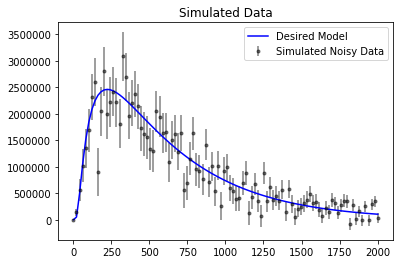

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import celerite as ce
from celerite.modeling import Model
import QPP_Funcs as QPP
from scipy.optimize import minimize

#setting our desired parameters that we want to "find"
paramstrue = [1e3, 1e-2, 3.2e+06, 1e+02, 5e+02]
log_paramstrue = np.log(paramstrue)

#defining a model class in celerite with our continuous model
class CTSModel_prior(Model):
    parameter_names = ("log_A", "log_tau1", "log_tau2")
    
    def get_value(self, t):
        A = np.e**self.log_A
        tau1 = np.e**self.log_tau1
        tau2 = np.e**self.log_tau2
        lam = np.exp(np.sqrt(2*(tau1/tau2)))
        return A*lam*np.exp((-tau1/t)-(t/tau2))
    
    #the gradient terms were manually calculated
    def compute_gradient(self, t):
        A = np.e**self.log_A
        tau1 = np.e**self.log_tau1
        tau2 = np.e**self.log_tau2
        lam = np.exp(np.sqrt(2*(tau1/tau2)))
        dA = (1./A) * self.get_value(t)
        dtau1 = ((1/(tau2 * np.log(lam))) - (1/t)) * self.get_value(t)
        dtau2 = ((t/(tau2**2)) - (tau1/((tau2**2) * np.log(lam)))) * self.get_value(t)
        return np.array([dA, dtau1, dtau2])
    
    
    #somewhat naive prior, a simple tophat distribution for each parameter
    def log_prior(self):
        prob = np.e
        T=2000.
        if not (self.log_A>-np.inf and self.log_A<np.log(3.5e7)) and (self.log_tau1>-np.inf and self.log_tau1<np.log(T)) and (self.log_tau2>-np.inf and self.log_tau2<np.log(T)):
            return -np.inf
        return np.log(prob)

model = CTSModel_prior(log_A = log_paramstrue[2], log_tau1 = log_paramstrue[3], log_tau2 = log_paramstrue[4])    

#generating our simulated data
N = 100
x = np.linspace(1,2001,N)
ytrue = model.get_value(x)
yerrscale = 3e2
yerr = np.sqrt(ytrue) * yerrscale
plt.plot(x, ytrue, 'b-', label = "Desired Model")

def simulate(x, yerr, model, A=0.1, c=0.5):
    #generates a covariance matrix and then data using the multivariate normal distribution
    #could this be where the error is????
    K = A*np.exp(-c*(x[:, None] - x[None, :]))
    K[np.diag_indices(len(x))] += yerr**2
    y = np.random.multivariate_normal(model.get_value(x), K)
    return y

ysim = simulate(x, yerr, model, A=paramstrue[0], c=paramstrue[1])

plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.title("Simulated Data")
plt.legend()
plt.show()


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Initial log-likelihood: -1375.3064339
True log-likelihood: -1375.651558
Final log-likelihood: -1375.15115153
      fun: 1375.1511515297896
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.95786897e-01,  -1.26750678e-90,   1.30409773e-05,
         3.43295808e-02,   3.37987746e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 28
      nit: 3
   status: 0
  success: True
        x: array([  5.85860219,   2.30258509,  14.97865627,   4.60867686,   6.2351596 ])


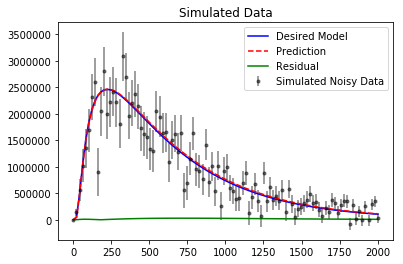

In [2]:
#define a class for our kernel function in celerite
class RealTerm_Prior(ce.terms.RealTerm):

    def log_prior(self):
        prob_a = 1.
        prob_c = 1.
        
        #again, using simple (naive) tophat distributions
        if not ((self.log_a > np.log(0)) and (self.log_a < np.log(1e6))):
            prob_a = 0.
        if not (self.log_c > np.log(1./1000) and self.log_c < np.log(100)):
            prob_c = 0.
        return np.log(prob_a*prob_c * np.e)


#initializing kernal and GP
kernel = RealTerm_Prior(log_a = np.log(500), log_c = np.log(10))
gp = ce.GP(kernel, mean = model, fit_mean = True)
gp.compute(x, yerr)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(ysim)))

#defining fitting functions for our GP
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

#setting initial terms and then optimizing
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

gp.set_parameter_vector(log_paramstrue)
print("True log-likelihood: {0}".format(gp.log_likelihood(ysim)))

gp.set_parameter_vector(initial_params)
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like, method="L-BFGS-B", bounds=bounds, args=(ysim, gp))

gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))
print soln
ytest, yvar = gp.predict(ysim, x, return_var=True)
ystd = np.sqrt(yvar)


#plotting our predictions as well as our original data and fit model
plt.plot(x, ytrue, 'b-', label = "Desired Model")
plt.plot(x, ytest, 'r--', label = "Prediction")
plt.fill_between(x, ytest+ystd, ytest-ystd, color='r', alpha=0.3, edgecolor='none')
plt.plot(x, np.abs(ytrue-ytest), 'g-', label = "Residual")
plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.title("Simulated Data")
plt.legend()


plt.show()


In [3]:
#choosing a startpoint from our optimizer (ignoring kernel terms because the optimizer messes those up for some reason)

paramstart = np.random.multivariate_normal(log_paramstrue, np.identity(len(log_paramstrue)) * np.sqrt(np.abs(log_paramstrue)))
gp.set_parameter_vector(paramstart)
gp.compute(x, yerr)
#probability function for MCMC
def log_probability(params, y, gp):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not (np.isfinite(gp.log_likelihood(y))):
        return np.inf
    if not (np.isfinite(lp)):
        return -np.inf
    return gp.log_likelihood(y) + lp


#sampling function for mcmc
def samplepdf(params):
    return np.random.normal(loc=params, scale = np.sqrt(np.abs(params)/10000.))

#step function for mcmc
def MCMCStep(gp, params, y, q, lfunc):
    newparams = q(params)
    r = np.random.rand()
    prob1 = lfunc(params, y, gp)
    prob2 = lfunc(newparams, y, gp)
    if(prob2 == np.inf):
        gp.set_parameter_vector(params)
        return True, newparams
    if((prob2/prob1)>r):
        return False, newparams
    else:
        gp.set_parameter_vector(params)
        return False, params
    
N = int(1e4)
paramset=np.empty([N,5])
paramset[0] = paramstart
bad = False
badparams = []
accept = 0.
print "Running MCMC..."
#running step function many times
for i in range(N-1):
    try:
        bad, paramset[i+1] = MCMCStep(gp, paramset[i], ysim, samplepdf, log_probability)
        if(bad == True):
            bad = False
            badparams.append(paramset[i+1])
            paramset[i+1] = paramset[i]
        if not (paramset[i+1]==paramset[i]).all():
            accept+=1
    except(RuntimeError):
        i-=1
print("Acceptance ratio = {}".format(accept/N))
print("Bad params ratio = {}".format(float(len(badparams))/float(N)))

Running MCMC...


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Acceptance ratio = 0.9998
Bad params ratio = 0.0


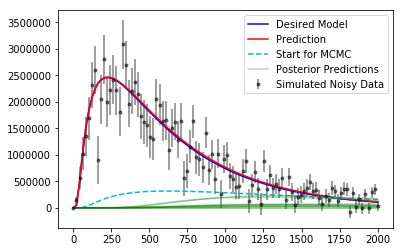

In [4]:
#plotting a sampling of results from MH MCMC along with my previous work

plt.plot(x, ytrue, 'b-', label = "Desired Model")
plt.plot(x, ytest, 'r-', label = "Prediction")
plt.fill_between(x, ytest+ystd, ytest-ystd, color='r', alpha=0.3, edgecolor='none')
plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

model.set_parameter_vector(paramstart[2:])
ystart = model.get_value(x)
plt.plot(x, ystart, 'c--', label = "Start for MCMC")

labeled = False
for i in range(N/1000):
    params = paramset[np.random.randint(len(paramset)),2:]
    model.set_parameter_vector(params)
    
    ymc = model.get_value(x)
    if not np.isnan(ymc).any():
        if labeled == False:
            plt.plot(x, ymc, 'g-', alpha = 0.3, label = "Posterior Predictions")
            labeled = True
        else:  
            plt.plot(x, ymc, 'g-', alpha = 0.3)

plt.legend()    
plt.show()

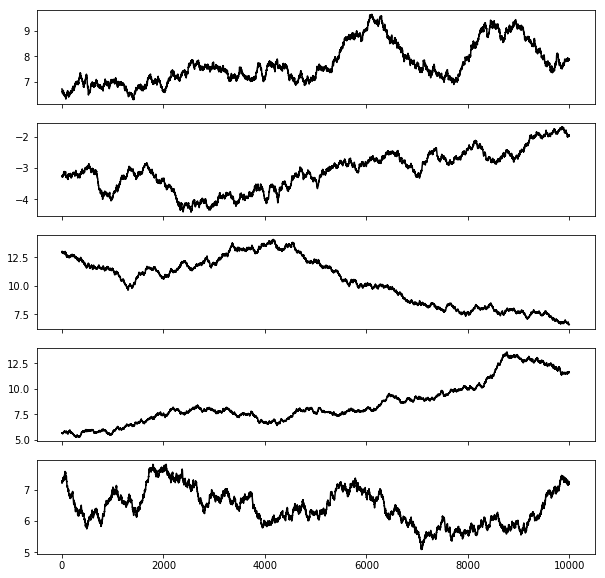

In [5]:
#plotting time series of MCMC

fig, axarr = plt.subplots(5, sharex=True, figsize = (10,10))
xline = np.arange(N)

for i in range(5):
    axarr[i].plot(np.arange(N), paramset[:,i], 'k-')

plt.show()

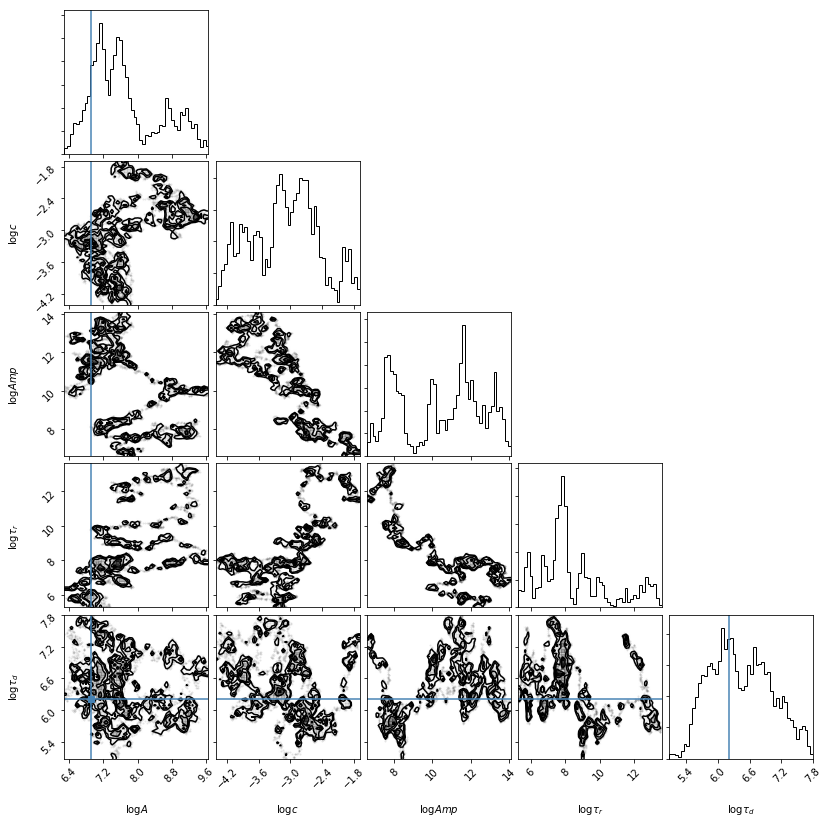

In [6]:
import corner
names = gp.get_parameter_names()
corner.corner(paramset, bins=50, labels = [r"$\log{A}$", r"$\log{c}$", r"$\log{Amp}$", r"$\log{\tau_r}$", r"$\log{\tau_d}$"], truths=log_paramstrue)
plt.show()

In [7]:
#initializing and running emcee sampler using same startpoint as MH-MCMC

import emcee

ndim = 5
nwalkers = 100
nsteps = 1000
start = [samplepdf(paramstart) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ysim, gp))
sampler.run_mcmc(start, nsteps)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


(array([[  2.14173926e+00,   2.49780427e+00,   1.48561785e+01,
           4.59413723e+00,   6.31576469e+00],
        [  1.99793015e+00,   3.05272437e+00,   1.48993331e+01,
           4.28747136e+00,   6.29198890e+00],
        [  5.96817222e-01,  -2.28680214e+00,   1.47816717e+01,
           4.41299083e+00,   6.36726652e+00],
        [  3.15622056e+00,   4.43165436e-01,   1.48762846e+01,
           4.51971578e+00,   6.29864112e+00],
        [  1.63073090e+00,   1.39270100e+00,   1.48546531e+01,
           4.47407510e+00,   6.31946302e+00],
        [ -7.88328605e-02,  -1.79893345e+00,   1.49431942e+01,
           4.46009541e+00,   6.29626202e+00],
        [  8.04475383e-01,  -6.06970937e+00,   1.48494465e+01,
           4.61091620e+00,   6.28545293e+00],
        [  4.22316983e+00,  -4.31812382e+00,   1.47907875e+01,
           4.37585526e+00,   6.33215963e+00],
        [  3.51250647e+00,   3.50807473e+00,   1.49260368e+01,
           4.57728726e+00,   6.26546244e+00],
        [  9.152073

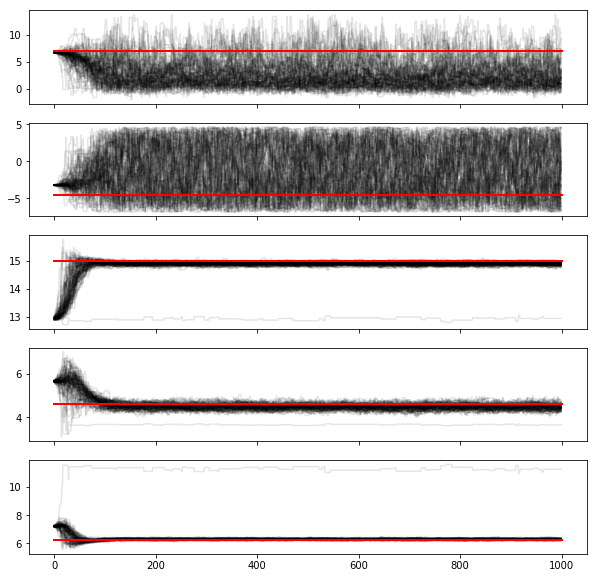

In [8]:
fig, axarr = plt.subplots(5, sharex=True, figsize = (10,10))
xline = np.linspace(0,nsteps)

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot(np.arange(nsteps), sampler.chain[i,:,j], 'k-', alpha=0.1)
        trueval = log_paramstrue[j] * np.ones(len(xline))
        axarr[j].plot(xline, trueval, 'r-')
plt.show()

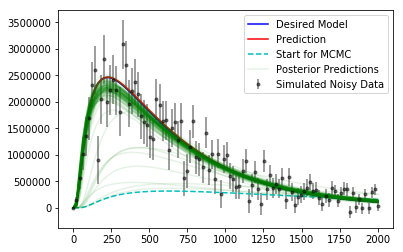

In [9]:
#plotting a sampling of results from emcee MCMC along with my previous work

plt.plot(x, ytrue, 'b-', label = "Desired Model")
plt.plot(x, ytest, 'r-', label = "Prediction")
plt.fill_between(x, ytest+ystd, ytest-ystd, color='r', alpha=0.3, edgecolor='none')
plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

model.set_parameter_vector(paramstart[2:])
ystart = model.get_value(x)
plt.plot(x, ystart, 'c--', label = "Start for MCMC")

labeled = False
for i in range(nsteps/10):
    params = sampler.chain[np.random.randint(nwalkers),np.random.randint(nsteps),2:]
    model.set_parameter_vector(params)
    
    ymc = model.get_value(x)
    if not np.isnan(ymc).any():
        if labeled == False:
            plt.plot(x, ymc, 'g-', alpha = 0.1, label = "Posterior Predictions")
            labeled = True
        else:  
            plt.plot(x, ymc, 'g-', alpha = 0.1)

plt.legend()    
plt.show()

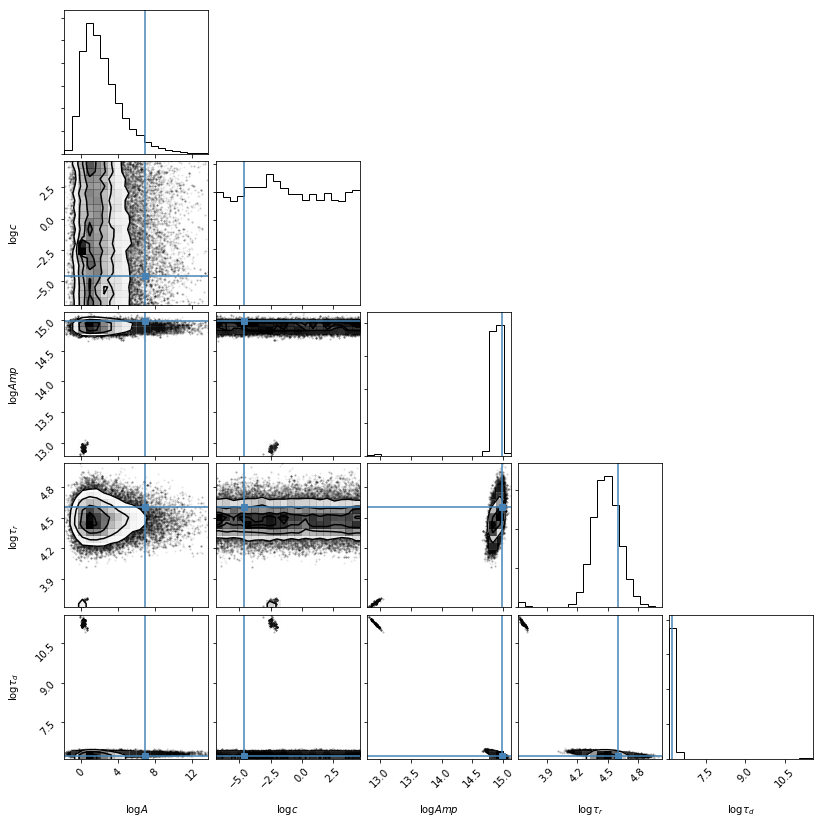

[  6.90775528  -4.60517019  14.97866137   4.60517019   6.2146081 ]


In [10]:
flat_samples = sampler.chain[:,200:, :].reshape((-1,ndim))
fig = corner.corner(flat_samples, labels = [r"$\log{A}$", r"$\log{c}$", r"$\log{Amp}$", r"$\log{\tau_r}$", r"$\log{\tau_d}$"], truths = log_paramstrue)
plt.show()
print log_paramstrue